<a href="https://colab.research.google.com/github/detauportuno/Projeto_Pinturas_PAE/blob/main/Aula6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução à inteligência artificial

## Aula 6 - Redes neurais convolucionais

Nesta aula, visualizaremos quatro saídas filtradas (também conhecidas como mapas de ativação) de uma camada convolucional.

Neste exemplo, *nós* estamos definindo quatro filtros que são aplicados a uma imagem de entrada, inicializando os **pesos** de uma camada convolucional, mas uma CNN treinada aprenderá os valores desses pesos.

In [ ]:
# Download da foto
!wget https://imagens-revista.vivadecora.com.br/uploads/2018/05/tipos-de-flores-g%C3%A9rbera.jpg -O image.jpg

--2024-03-02 11:25:50--  https://imagens-revista.vivadecora.com.br/uploads/2018/05/tipos-de-flores-g%C3%A9rbera.jpg
Resolving imagens-revista.vivadecora.com.br (imagens-revista.vivadecora.com.br)... 18.154.132.105, 18.154.132.96, 18.154.132.88, ...
Connecting to imagens-revista.vivadecora.com.br (imagens-revista.vivadecora.com.br)|18.154.132.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74112 (72K) [image/webp]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  72.38K   216KB/s    in 0.3s    

2024-03-02 11:25:51 (216 KB/s) - ‘image.jpg’ saved [74112/74112]



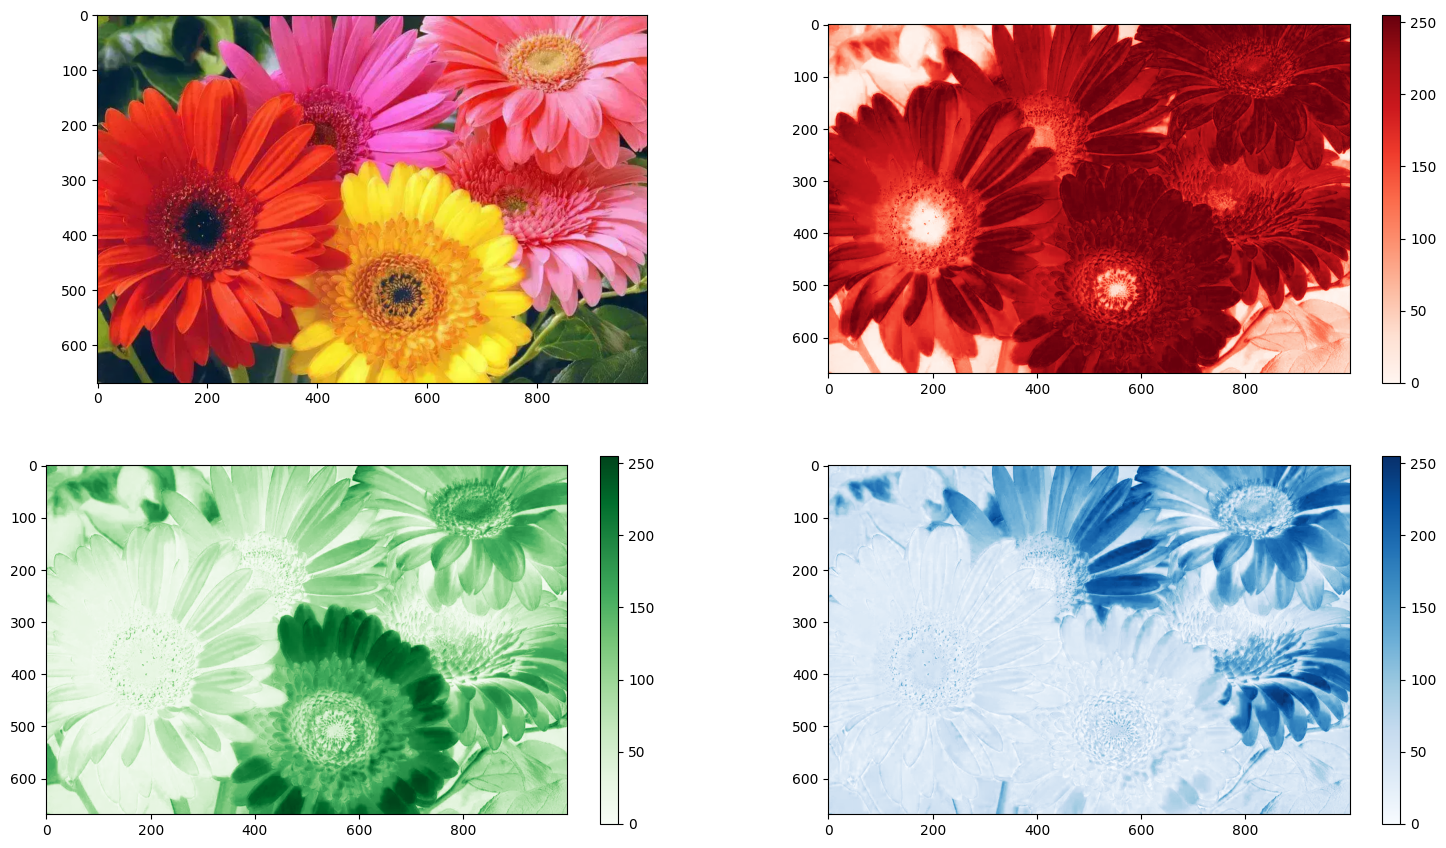

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
%matplotlib inline

# Fique a vontade para usar qualquer outra image,
img_path = '/content/image.jpg'

# Carrega a imagem colorida
bgr_img = cv2.imread(img_path)
rgb_img = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
# Converte para escala de cinza
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# Separa os canais
red = rgb_img[:, :, 0]
green = rgb_img[:, :, 1]
blue = rgb_img[:, :, 2]

fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)

cax_00 = axs[0,0].imshow(rgb_img)

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
plt.show()


Para aplicar os filtros a seguir nós iremos realizar uma operação chamada convolução, onde o filtro é chamado de "kernel" que é uma matriz.

Exemplo de convolução:
<div align=center>
<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif">
</div>

### Defina e visualize os filtros

In [ ]:
## Sinta-se a vontade para modificar os filtros
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Formato do filtro: ', filter_vals.shape)

Formato do filtro:  (4, 4)


In [ ]:
# Definindo quatro filtros, sendo todos combinações lineares de 'filter_vals'

# Definindo quatro filtros
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# Por exemplo, mostrando o primeiro filtro
print('Filtro 1: \n', filter_1)

Filtro 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]


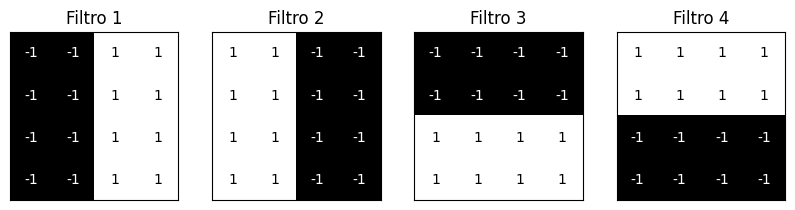

In [ ]:
# Visualizando os quatro filtros
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filtro %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

### Definir uma camada convolucional

As várias camadas que compõem qualquer rede neural estão documentadas, [aqui](http://pytorch.org/docs/stable/nn.html). Para uma rede neural convolucional, começaremos definindo a:
* Camada convolucional

Inicialize uma única camada convolucional para que ela contenha todos os filtros criados. Observe que você não está treinando esta rede; você está inicializando os pesos em uma camada convolucional para poder visualizar o que acontece depois de uma passagem direta por essa rede!

In [ ]:
# Transforma os filtros para tensor
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
# Pega as dimensões do filtro
k_height, k_width = weight.shape[2:]
# Cria a camada convolucional
conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
# Inicializa os ganhos do kernel com os filtros
conv.weight = nn.Parameter(weight)
# Cria o modelo
model = nn.Sequential(conv)
# Mostra o modelo
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [ ]:
model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

### Visualize a saída de cada filtro

Primeiro, definiremos uma função auxiliar, `viz_layer`, que capta uma camada específica e um número de filtros (argumento opcional), e exibe a saída dessa camada depois que uma imagem é passada.

In [ ]:
# Função auxiliar para visualizar a saida de cada camada
# Quantidade de filtros por padrão é 4 para essa função
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))

    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Saida %s' % str(i+1))

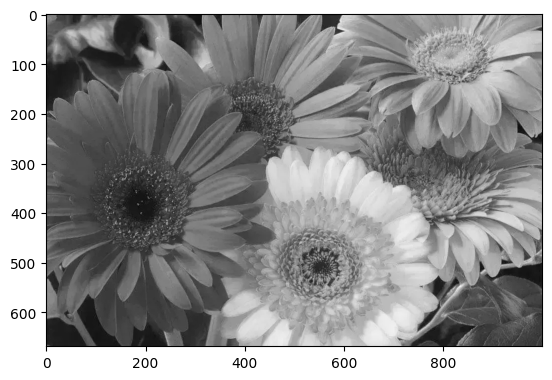

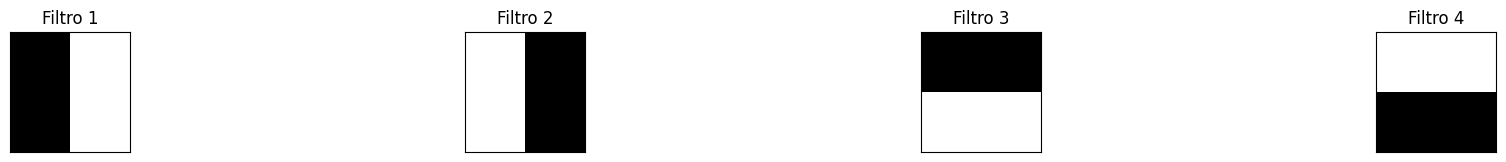

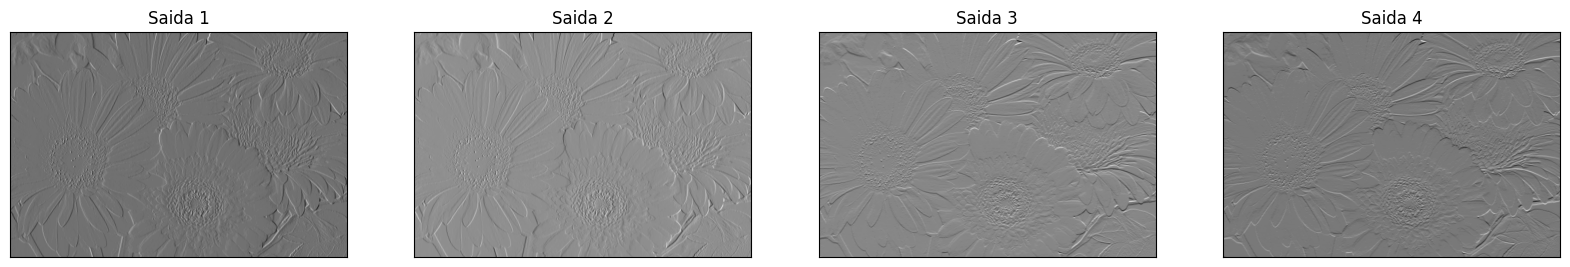

In [ ]:
# Plota a imagem original
plt.imshow(gray_img, cmap='gray')

# Visualiza os filtros
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filtro %s' % str(i+1))


# Converte a imagem em um tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1).type(torch.FloatTensor)

# get the convolutional layer (pre and post activation)
conv_layer  = model(gray_img_tensor)

# visualize the output of a conv layer
viz_layer(conv_layer)

#### Ativação ReLu

Neste modelo, usamos uma função de ativação que escala a saída da camada convolucional. Escolhemos uma função ReLu para fazer isso, e essa função simplesmente transforma todos os valores negativos de pixel em zeros (preto).

In [ ]:
# Modelo com ativação ReLu

# Transforma os filtros para tensor
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
# Pega as dimensões do filtro
k_height, k_width = weight.shape[2:]
# Cria a camada convolucional
conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
# Inicializa os ganhos do kernel com os filtros
conv.weight = nn.Parameter(weight)
# Cria o modelo
model = nn.Sequential(conv,
                      nn.ReLU())
# Mostra o modelo
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): ReLU()
)


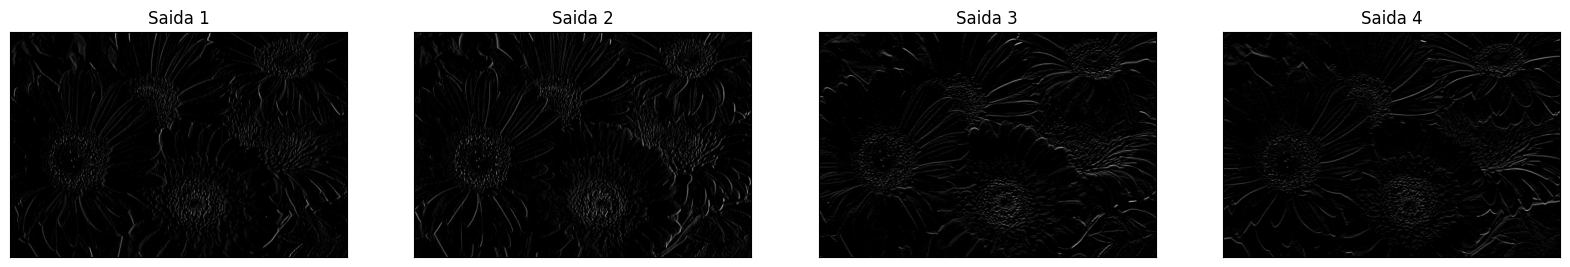

In [ ]:
# Passando imagem pelo modelo
activated_layer = model(gray_img_tensor)
# Visualizar a imagem com ativação ReLu
viz_layer(activated_layer)

### Camada "Maxpooling"

Agora adicionaremos uma camada "Maxpooling" na sequência de uma camada convolucional.
Uma camada convolucional + função de ativação, seguida por uma camada de pool e uma camada linear (para criar o tamanho de saída desejado) compõem as camadas básicas de uma CNN.

Você já viu como definir uma camada convolucional, a seguir é uma:
* Camada "pooling"

Na próxima célula, inicializamos uma camada convolucional para que ela contenha todos os filtros criados. Em seguida, adicione uma camada de maxpool, [documentada aqui](http://pytorch.org/docs/stable/_modules/torch/nn/modules/pool.html), com um tamanho de kernel de (2x2), para que você possa ver o a resolução da imagem foi reduzida após esta etapa!

Uma camada de maxpool reduz o tamanho x-y de uma entrada e mantém apenas os valores mais *ativos* de pixel. Abaixo está um exemplo de um kernel de pool 2x2, com um passo de 2, aplicado a um pequeno patch de valores de pixel em escala de cinza; reduzindo o tamanho x-y do patch em um fator de 2. Somente os valores máximos de pixel em 2x2 permanecem na nova saída.

In [ ]:
# Transforma os filtros para tensor
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
# Pega as dimensões do filtro
k_height, k_width = weight.shape[2:]
# Cria a camada convolucional
conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
# Inicializa os ganhos do kernel com os filtros
conv.weight = nn.Parameter(weight)
# Cria o modelo com "Maxpooling"
model = nn.Sequential(conv,
                      nn.MaxPool2d(2, 2))
# Mostra o modelo
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


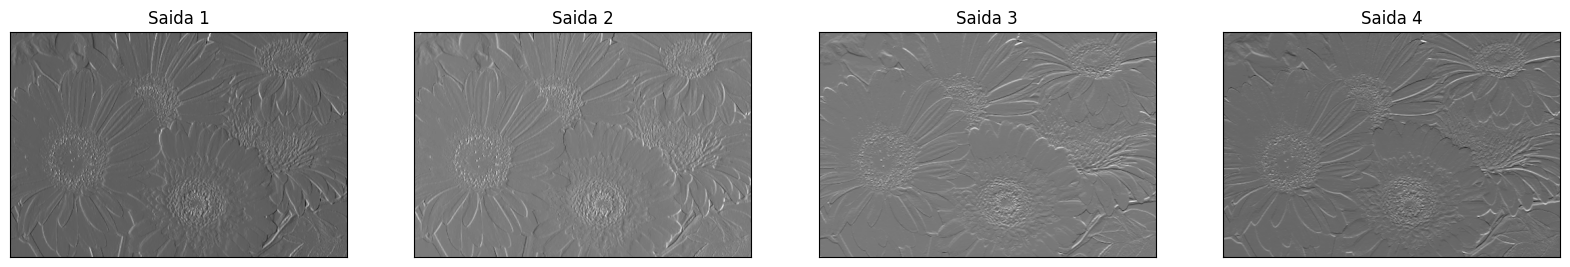

In [ ]:
# Passando imagem pelo modelo
maxpool_layer = model(gray_img_tensor)
# Visualizar a imagem com maxpooling
viz_layer(maxpool_layer)

#### Ativação ReLu

Neste modelo, usamos uma função de ativação que escala a saída da camada maxpooling. Escolhemos uma função ReLu para fazer isso, e essa função simplesmente transforma todos os valores negativos de pixel em zeros (preto).

In [ ]:
# Modelo com maxpooling e ReLu

# Transforma os filtros para tensor
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
# Pega as dimensões do filtro
k_height, k_width = weight.shape[2:]
# Cria a camada convolucional
conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
# Inicializa os ganhos do kernel com os filtros
conv.weight = nn.Parameter(weight)
# Cria o modelo com "Maxpooling"
model = nn.Sequential(conv,
                      nn.MaxPool2d(2, 2),
                      nn.ReLU())
# Mostra o modelo
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
)


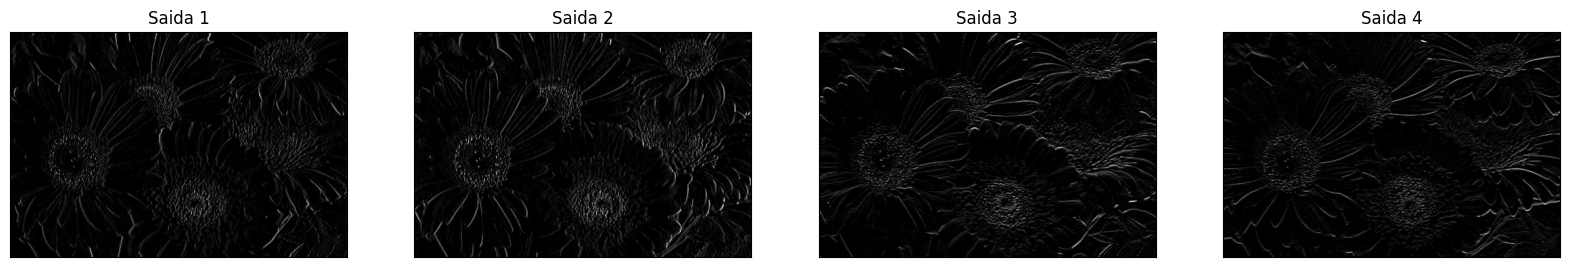

In [ ]:
# Passando imagem pelo modelo
activated_maxpool_layer = model(gray_img_tensor)
# Visualizar a imagem com maxpooling e ativação ReLu
viz_layer(activated_maxpool_layer)

### Montando uma CNN para classificação

Vamos montar uma **CNN** para classificar imagens do banco de dados CIFAR-10.

As imagens neste banco de dados são pequenas imagens coloridas que se enquadram em uma das dez classes; alguns exemplos de imagens são mostrados abaixo.

<div align=center>
<img src="https://i2.wp.com/appliedmachinelearning.blog/wp-content/uploads/2018/03/cifar2.jpg?fit=427%2C325&ssl=1">
</div>

### [CUDA](http://pytorch.org/docs/stable/cuda.html)

Como são imagens maiores (32x32x3), pode ser útil acelerar o tempo de treinamento usando uma GPU. O CUDA é uma plataforma de computação paralela e os Tensores CUDA são os mesmos que os Tensores típicos, apenas eles utilizam GPUs para computação.

In [ ]:
# Checa se tem GPU disponível
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA não está disponível. Treinando na CPU ...')
else:
    print('CUDA está disponível! Treinando na GPU ...')

CUDA está disponível! Treinando na GPU ...


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Número de subprocessos a serem usados para carregamento de dados
num_workers = 0

# Quantas amostras por lote
batch_size = 20

# Porcentagem de treinamento definida para uso como validação
valid_size = 0.2

# Define as transformações
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Baixa as informações
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# Obter índices de treinamento que serão usados para validação
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Definir amostradores para obter lotes de treinamento e validação
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Preparar carregadores de dados (combinar conjunto de dados e amostrador)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# Especifica as classes das imagens
classes = ['avião', 'automóvel', 'pássaro', 'gato', 'cervo',
           'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

100%|██████████| 170498071/170498071 [00:03<00:00, 43513152.94it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize um lote de dados de treinamento


In [ ]:
# Função auxiliar
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

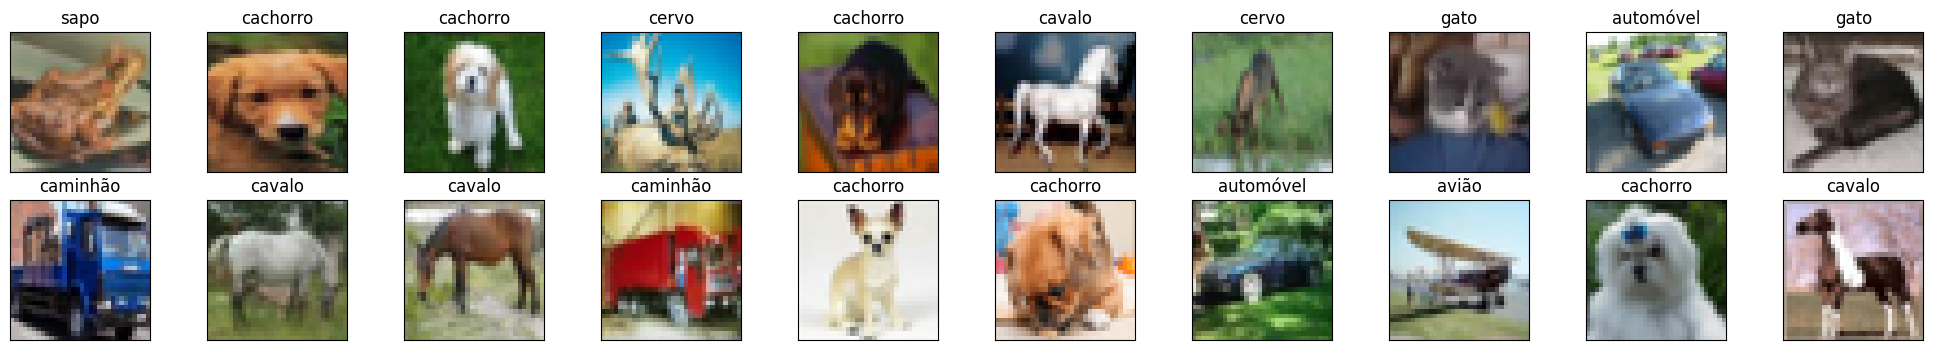

In [ ]:
# Obtém um lote de imagens
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
# Mostra 20 imagens
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Ver uma imagem em mais detalhes

Aqui, examinamos os canais de cores normalizados de vermelho, verde e azul (RGB) como três imagens separadas de intensidade em escala de cinza.

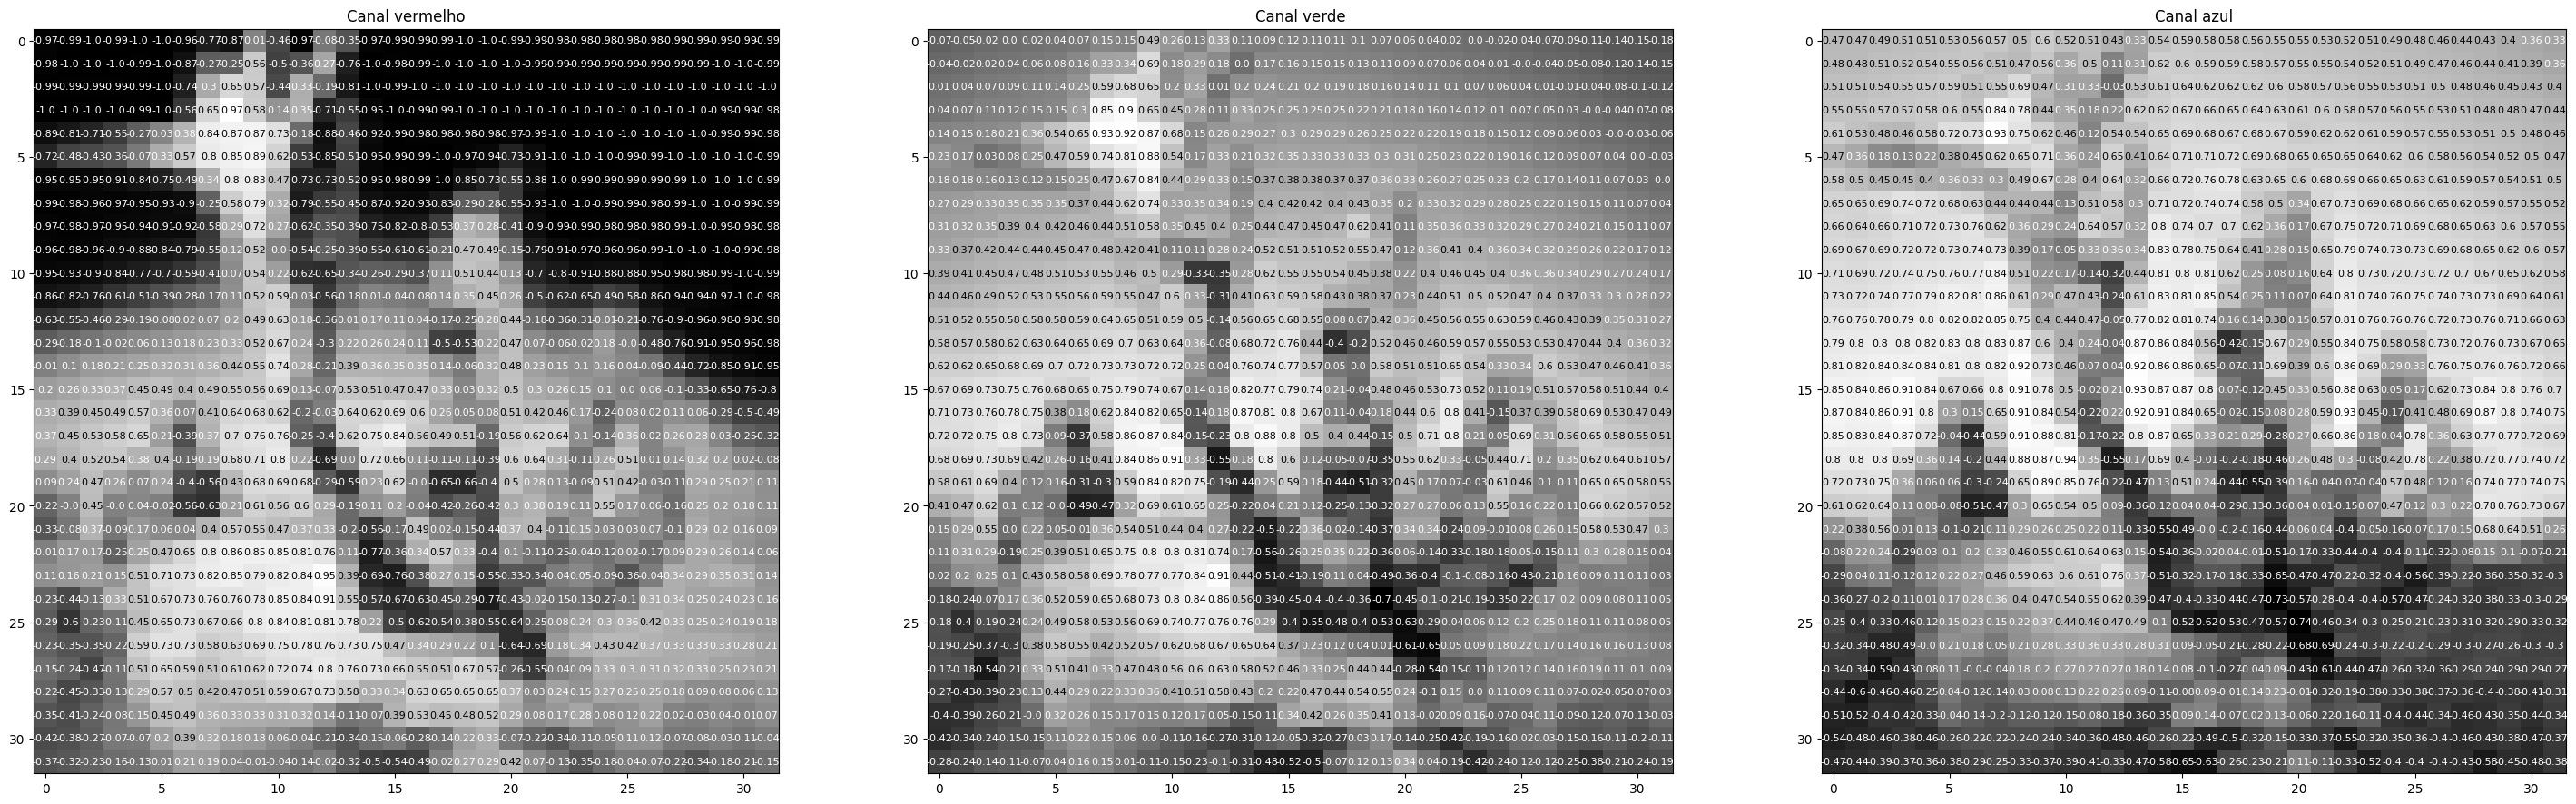

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['Canal vermelho', 'Canal verde', 'Canal azul']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

### Definir a [arquitetura da rede](http://pytorch.org/docs/stable/nn.html)

Desta vez, você definirá uma arquitetura da CNN. Em vez de camadas lineares totalmente conectadas, você usará o seguinte:
* [Camadas convolucionais](https://pytorch.org/docs/stable/nn.html#conv2d), que pode ser pensado como uma pilha de imagens filtradas.
* [Camadas de Maxpool](https://pytorch.org/docs/stable/nn.html#maxpool2d), que reduzem o tamanho x de uma entrada, mantendo apenas os pixels mais _ativos_ da camada anterior.
* As camadas Linear + Dropout usuais para evitar ajustes excessivos e produzir uma saída de 10 "classes".

Uma rede com 2 camadas convolucionais é mostrada na imagem abaixo e no código, e você recebeu um código de início com uma camada convolucional e uma camada máxima.

<div align=center>
<img src = 'https://missinglink.ai/wp-content/uploads/2019/06/CNN-Architecture-Types-of-Layers-700x376.png' height = 20% largura = 20% />
</div>

#### TODO: Defina um modelo com várias camadas convolucionais e defina o comportamento da meta de feedforward.

Quanto mais camadas convolucionais você incluir, mais padrões complexos de cores e formas um modelo poderá detectar. Sugere-se que seu modelo final inclua 2 ou 3 camadas convolucionais, bem como camadas lineares + "dropout" entre elas, para evitar "overfitting".

É uma boa prática considerar as pesquisas e implementações existentes de modelos relacionados como ponto de partida para definir seus próprios modelos. Pode ser útil consultar [este exemplo de classificação do PyTorch](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) ou [este, exemplo mais complexo do Keras](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) para ajudar a decidir sobre uma estrutura final.

#### Volume de saída para uma camada convolucional

Para calcular o tamanho da saída de uma determinada camada convolucional, podemos realizar o seguinte cálculo (retirado de [curso cs231n de Stanford](http://cs231n.github.io/convolutional-networks/#layers)):
> Podemos calcular o tamanho espacial do volume de saída em função do tamanho do volume de entrada (W), do tamanho do kernel / filtro (F), do passo com o qual eles são aplicados (S) e da quantidade de preenchimento zero usada (P) na fronteira. A fórmula correta para calcular quantos neurônios definem a saída_W é dada por `(W-F + 2P)/S + 1`.

Por exemplo, para uma entrada 7x7 e um filtro 3x3 com passada 1 e pad 0, obteríamos uma saída 5x5. Com o passo 2 obteríamos uma saída 3x3.

In [ ]:
#TODO: Crie o seguinte modelo
model = nn.Sequential(
        # Camada convolucional que entra um tensor 32x32x3, kernel = 3, "stride"= 1 e "padding" = 1
        nn.Conv2d(3,16,3,1,1),
        # Camada "maxpooling" com kernel = 2 e "stride"= 2
        nn.MaxPool2d(2, 2),
        # Função de ativação
        nn.ReLU(),
        # Camada convolucional que entra um tensor 16x16x16, kernel = 3, "stride"= 1 e "padding" = 1
        nn.Conv2d(16,32,3,1,1),
        # Camada "maxpooling" com kernel = 2 e "stride"= 2
        nn.MaxPool2d(2, 2),
        # Função de ativação
        nn.ReLU(),
        # Camada convolucional que entra um tensor 8x8x32, kernel = 3, "stride"= 1 e "padding" = 1
        nn.Conv2d(32,64,3,1,1),
        # Camada "maxpooling" com kernel = 2 e "stride"= 2
        nn.MaxPool2d(2, 2),
        # Função de ativação
        nn.ReLU(),
        # Achata a imagem
        nn.Flatten(),
        # Camada linear que entra 4x4x64 e sai valor x
        nn.Linear(4, 4, 64, x),
        # Função de ativação
        nn.ReLU(),
        # Camada "dropout" (p=0.25)
        None,
        # Camada linear que entra x e sai 10 classes
        None,
        # Função de ativação
        nn.ReLU(),
        # Camada "dropout" (p=0.25)
        None)

if train_on_gpu:
    model.cuda()


In [ ]:
import torch.optim as optim

# Especificando o critério
criterion = nn.CrossEntropyLoss()

# Especificando o otimizador
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Treine a rede

Lembre-se de observar como a perda de treinamento e validação diminui com o tempo; se a perda de validação aumentar, isso indica um possível "overfitting".

In [ ]:
# Número de épocas
n_epochs = 2

valid_loss_min = np.Inf # Rastreia o valor minimo de validação

for epoch in range(1, n_epochs+1):

    # Rastreia as perdas
    train_loss = 0.0
    valid_loss = 0.0

    # Treinamento
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensores para CUDA se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Limpa o gradiente do otimizador
        optimizer.zero_grad()
        # Faz a inferência do lote
        output = model(data)
        # Calcula a perda do lote
        loss = criterion(output, target)
        # Faz um "passe para trás" para obter os erros
        loss.backward()
        # Da um passo no otimizador
        optimizer.step()

        train_loss += loss.item()*data.size(0)

    # Validação
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # Move tensores para CUDA se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Faz a inferência do lote
        output = model(data)
        # Calcula a perda do lote
        loss = criterion(output, target)
        # Atualiza o erro
        valid_loss += loss.item()*data.size(0)

    # Calcula as perdas
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    print('Época: {} \tPerda de treino: {:.6f} \tPerda de validação: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # Salva modelo se a perda de validação diminuiu
    if valid_loss <= valid_loss_min:
        print('Perda de validação caiu! ({:.6f} --> {:.6f}).  Salvando modelo ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

### Carregar o modelo

In [ ]:
model.load_state_dict(torch.load('model.pt'))

### Teste a rede treinada

Teste seu modelo treinado em dados nunca vistos antes! Um resultado "bom" será uma CNN com cerca de 70% (ou mais, tente o seu melhor!) De precisão nessas imagens de teste.

In [ ]:

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for batch_idx, (data, target) in enumerate(test_loader):

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Perda de teste: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Precisão de teste de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Precisão de teste de %5s: N/A (Sem exemplo de teste)' % (classes[i]))

print('\nPrecisão de teste geral: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))